# 10_Deep_Learning_with_Keras
Feed-forward Multiclass MLP
## Ray Hossain

## Setup

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix

# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt

import seaborn as sns

## Pre-Processing Outside

In [2]:
df = pd.read_csv('Processed_Data/81_TopicLDA_Wide.csv')

In [3]:
df['secondvote'] = df['secondvote'].replace(7, 0)

In [4]:
df.secondvote.value_counts()

secondvote
2    265
0    240
1    225
5    217
6    173
3    115
4    109
Name: count, dtype: int64

In [5]:
df.fillna({'duration': 0}, inplace=True)

## Model

In [6]:
from tensorflow.keras.layers import Input  # Add this import at the top
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

def build_political_classification_model(df, test_size=0.2, random_state=42):
    """
    Build and train a neural network for political affiliation classification
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the features and target variable
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    model : trained Keras model
    history : training history
    X_test : test features
    y_test : test labels
    preprocessor : fitted preprocessing pipeline
    """
    # Separate features into categories
    binary_one_hot_columns = ['ml_gender_female', 'ml_married', 'ml_employ', 'ml_degreestatus']
    categorical_columns = ['polinterest', 'adjustedincome']
    continuous_columns = [
        'duration', 'news_proportion', 'age', 
        'tf_idf_entity_weighted', 'Current Events', 'Economy', 
        'Elections', 'Entertainment', 'General', 'Law and Order', 
        'Politics', 'Sports', 'Unassigned'
    ]
    target_column = 'secondvote'
    
    # Preprocessing pipeline
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, continuous_columns),
            ('cat', categorical_transformer, categorical_columns),
            ('binary', 'passthrough', binary_one_hot_columns)
        ])
    
    # Split data
    X = df[continuous_columns + categorical_columns + binary_one_hot_columns]
    y = df[target_column].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Preprocess the data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    # Count number of unique classes
    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")
    
    # Model configuration
    output_activation = 'softmax'
    output_units = num_classes
    loss_function = 'sparse_categorical_crossentropy'
    
    # Build the model with proper input layer
    model = Sequential([
        Input(shape=(X_train.shape[1],)),  # Proper way to define input shape
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(output_units, activation=output_activation)
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss=loss_function,
        metrics=['accuracy']
    )
    
    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    return model, history, X_test, y_test, preprocessor

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on test data
    
    Parameters:
    -----------
    model : trained Keras model
    X_test : test features
    y_test : test labels
    """
    # Make predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate F1 scores
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print(f"\nF1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    
    return accuracy, y_pred

def plot_training_history(history):
    """
    Plot the training history (only loss and accuracy)
    
    Parameters:
    -----------
    history : training history object from model.fit()
    """
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

## Evaluation

Number of classes: 7
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1449 - loss: 2.6041 - val_accuracy: 0.1767 - val_loss: 1.9235
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1516 - loss: 2.4225 - val_accuracy: 0.2558 - val_loss: 1.9161
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1863 - loss: 2.2839 - val_accuracy: 0.2512 - val_loss: 1.9176
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1699 - loss: 2.2078 - val_accuracy: 0.2140 - val_loss: 1.9243
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2155 - loss: 2.0925 - val_accuracy: 0.2233 - val_loss: 1.9229
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1992 - loss: 2.0486 - val_accuracy: 0.1814 - val_loss: 1.9252
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2130 - loss: 2.0452 - val_accuracy: 0.1860 - val_loss: 1.9122
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2305 - loss: 1.9993 - va

c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

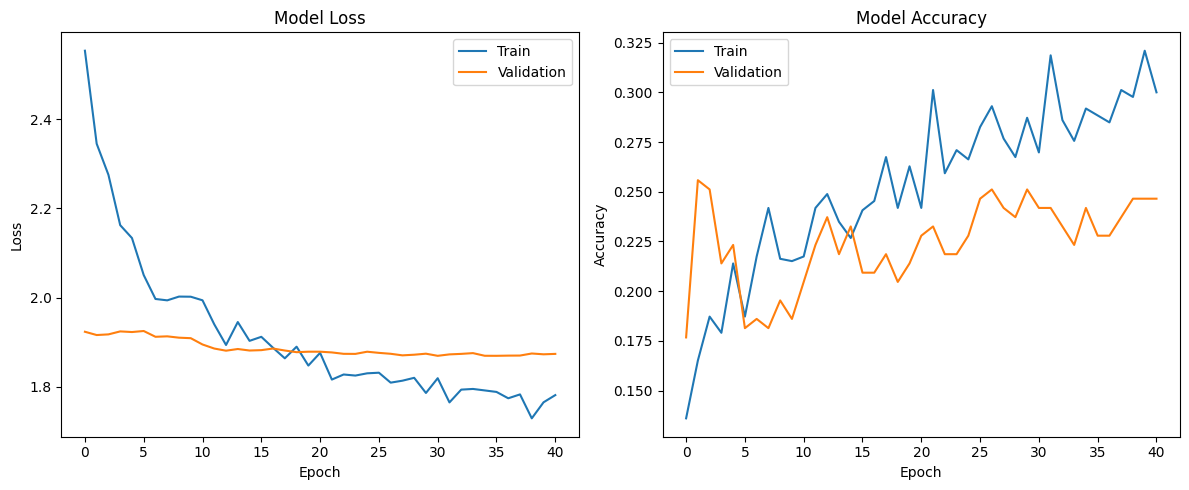

In [7]:
# Build and train the model
model, history, X_test, y_test, scaler = build_political_classification_model(df)

# Evaluate the model
accuracy, y_pred = evaluate_model(model, X_test, y_test)

# Plot training history
plot_training_history(history)


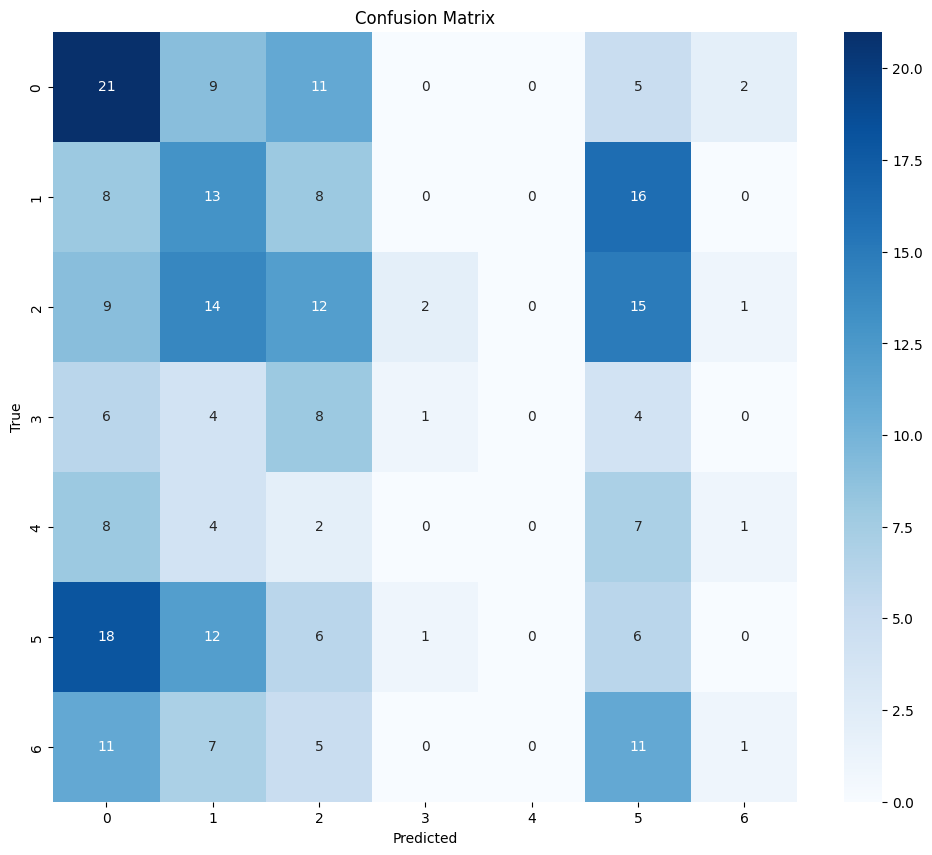

In [8]:

# Calculate confusion matrix explicitly
cm = confusion_matrix(y_test, y_pred)

# Create a more visually appealing confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.20074349442379183
